In [1]:
%pip uninstall tensorflow tensorflow-datasets tensorflow-metadata tf-keras tensorflow-hub tensorboard google-auth-oauthlib protobuf -y
%pip install google-auth-oauthlib==0.7.0
%pip install protobuf==4.25.0

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
Found existing installation: tensorflow-datasets 4.9.6
Uninstalling tensorflow-datasets-4.9.6:
  Successfully uninstalled tensorflow-datasets-4.9.6
Found existing installation: tensorflow-metadata 1.15.0
Uninstalling tensorflow-metadata-1.15.0:
  Successfully uninstalled tensorflow-metadata-1.15.0
Found existing installation: tf_keras 2.15.1
Uninstalling tf_keras-2.15.1:
  Successfully uninstalled tf_keras-2.15.1
Found existing installation: tensorflow-hub 0.16.1
Uninstalling tensorflow-hub-0.16.1:
  Successfully uninstalled tensorflow-hub-0.16.1
Found existing installation: tensorboard 2.15.2
Uninstalling tensorboard-2.15.2:
  Successfully uninstalled tensorboard-2.15.2
Found existing installation: google-auth-oauthlib 1.2.1
Uninstalling google-auth-oauthlib-1.2.1:
  Successfully uninstalled google-auth-oauthlib-1.2.1
Found existing installation: protobuf 3.20.3


In [1]:
%pip install tensorflow==2.9
%pip install sciann
%pip install wandb -U

In [ ]:
import numpy as np
from sciann import Variable, Functional, SciModel
from sciann.constraints import Data
import sciann as sn
import matplotlib.pyplot as plt
from tensorflow import keras
import time
import wandb
import pprint

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.9.0 
Python Version: 3.10.12 (main, Mar 22 2024, 16:50:05) [GCC 11.4.0] 



## 1.1. Ajuste de la curva $y = sin(x)$ en el intervalo $[0,2\pi]$.

Experimentación con el primer conjunto de entrenamiento

In [ ]:
# Generación de datos sintéticos.
x_true = np.linspace(0, np.pi*2, 10000)
y_true = np.sin(x_true)
dy_true = np.cos(x_true)

x_test = np.linspace(-np.pi*2, np.pi*2, 20000)
y_test = np.sin(x_test)

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'n_layers': {
        'values': [3,5,7]
        },
    'n_in_layer': {
        'values': [20,40,80]
    }
    }

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'n_in_layer': {'values': [20, 40, 80]},
                'n_layers': {'values': [3, 5, 7]}}}


In [ ]:
def sweep_train_sin_10000(config_defaults=None):
    with wandb.init(config=config_defaults,project="experimento-1-sin-10000"):

          # Definimos la estructura de la función que queremos aprender.
          x = Variable('x')
          y = Functional('y', x, wandb.config.n_layers*[wandb.config.n_in_layer], activation=(wandb.config.n_layers-2)*['tanh']+['g-cos', 'l-sin'])

          # Imponemos restricciones al modelo.
          dy_dx = sn.diff(y, x)
          c1 = Data(y)

          # Definimos el modelo.
          model = SciModel(x, [y, dy_dx], optimizer='adam',plot_to_file='sin.png')
          model.summary()

          start_time = time.time()

          # Entrenamiento.
          entrenamiento_sin = model.train(x_true,
                      [y_true, dy_true],
                      epochs=200,
                      learning_rate={"scheduler": "ExponentialDecay",
                                    "initial_learning_rate": 1e-3,
                                    "final_learning_rate": 1e-5,
                                    "decay_epochs": 10,
                                    "verify": False},
                      batch_size=32,
                      adaptive_weights={'method': "CLW", 'initial_weights': [0.1, 1.], 'final_weights': [2., 3.], 'curriculum_epochs': 20, "delay_epochs": 10},
                      save_weights={'path': 'test', 'freq': 100}
                      )

          print(f"Duración del entrenamiento: {time.time()-start_time}s. ")

          # Predicción
          y_pred = y.eval(model, x_test)
          wandb.log(
          {
              'loss': min(entrenamiento_sin.history['loss']),
              'val_loss': np.mean((y_test-y_pred)**2),
              'time': time.time() - start_time
          })
          wandb.finish()

In [ ]:
sweep_sin_10000 = wandb.sweep(sweep_config, project="experimento-1-sin-10000")

Create sweep with ID: wxzd4rno
Sweep URL: https://wandb.ai/vaatiper-Universidad%20de%20Granada/experimento-1-sin-10000/sweeps/wxzd4rno


In [ ]:
wandb.agent(sweep_sin_10000,function=sweep_train_sin_10000,count=15)

wandb: Agent Starting Run: bmcr0w2d with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 3
wandb: Currently logged in as: vaatiper (vaatiper-Universidad de Granada). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b_4 (Dense)              (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               44        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_5 (Dense)              (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               44        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_6 (Dense)              (None, 40)                1640  

wandb: Agent Starting Run: 7pe9gr36 with config:
wandb: 	n_in_layer: 80
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D80b (Dense)                (None, 80)                160       
                                                                 
 sci_rowdy_activation_layer   (None, 80)               84        
 (SciRowdyActivationLayer)                                       
                                                                 
 D80b_1 (Dense)              (None, 80)                6480      
                                                                 
 sci_rowdy_activation_layer_  (None, 80)               84        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D80b_2 (Dense)              (None, 80)                6480  

wandb: Agent Starting Run: 6dtr23qi with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b (Dense)                (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               24        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_1 (Dense)              (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               24        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_2 (Dense)              (None, 20)                420   

wandb: Agent Starting Run: l4gclu21 with config:
wandb: 	n_in_layer: 80
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D80b_3 (Dense)              (None, 80)                160       
                                                                 
 sci_rowdy_activation_layer   (None, 80)               86        
 (SciRowdyActivationLayer)                                       
                                                                 
 D80b_4 (Dense)              (None, 80)                6480      
                                                                 
 sci_rowdy_activation_layer_  (None, 80)               86        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D80b_5 (Dense)              (None, 80)                6480  

wandb: Agent Starting Run: cx923sx2 with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_3 (Dense)              (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               24        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_4 (Dense)              (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               24        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_5 (Dense)              (None, 20)                420   

wandb: Agent Starting Run: 1uxby7gk with config:
wandb: 	n_in_layer: 80
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D80b_8 (Dense)              (None, 80)                160       
                                                                 
 sci_rowdy_activation_layer   (None, 80)               86        
 (SciRowdyActivationLayer)                                       
                                                                 
 D80b_9 (Dense)              (None, 80)                6480      
                                                                 
 sci_rowdy_activation_layer_  (None, 80)               86        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D80b_10 (Dense)             (None, 80)                6480  

wandb: Agent Starting Run: 7meh9nv6 with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_6 (Dense)              (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               28        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_7 (Dense)              (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               28        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_8 (Dense)              (None, 20)                420   

wandb: Agent Starting Run: 70isphgv with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_13 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               28        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_14 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               28        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_15 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: 2xek8tq5 with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_20 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               26        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_21 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               26        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_22 (Dense)             (None, 20)                420   

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6i1fkgy6 with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_25 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               28        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_26 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               28        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_27 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: hhlkewpb with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_32 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               28        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_33 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               28        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_34 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: fqutfiwd with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b_7 (Dense)              (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               44        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_8 (Dense)              (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               44        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_9 (Dense)              (None, 40)                1640  

wandb: Agent Starting Run: iggbdmgy with config:
wandb: 	n_in_layer: 80
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D80b_13 (Dense)             (None, 80)                160       
                                                                 
 sci_rowdy_activation_layer   (None, 80)               86        
 (SciRowdyActivationLayer)                                       
                                                                 
 D80b_14 (Dense)             (None, 80)                6480      
                                                                 
 sci_rowdy_activation_layer_  (None, 80)               86        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D80b_15 (Dense)             (None, 80)                6480  

wandb: Agent Starting Run: 9qo2ufxq with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_39 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               24        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_40 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               24        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_41 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: 7kqfah95 with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b_10 (Dense)             (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               44        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_11 (Dense)             (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               44        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_12 (Dense)             (None, 40)                1640  

In [ ]:
wandb.finish()

In [ ]:
# Generación de datos sintéticos.
x_true = np.linspace(0, np.pi*2, 100)
y_true = np.sin(x_true)
dy_true = np.cos(x_true)

x_test = np.linspace(-np.pi*2, np.pi*2, 20000)
y_test = np.sin(x_test)

In [ ]:
def sweep_train_sin_100(config_defaults=None):
    with wandb.init(config=config_defaults,project="experimento-1-sin-100"):

          # Definimos la estructura de la función que queremos aprender.
          x = Variable('x')
          y = Functional('y', x, wandb.config.n_layers*[wandb.config.n_in_layer], activation=(wandb.config.n_layers-2)*['tanh']+['g-cos', 'l-sin'])

          # Imponemos restricciones al modelo.
          dy_dx = sn.diff(y, x)
          c1 = Data(y)

          # Definimos el modelo.
          model = SciModel(x, [y, dy_dx], optimizer='adam',plot_to_file='sin.png')
          model.summary()

          start_time = time.time()

          # Entrenamiento.
          entrenamiento_sin = model.train(x_true,
                      [y_true, dy_true],
                      epochs=200,
                      learning_rate={"scheduler": "ExponentialDecay",
                                    "initial_learning_rate": 1e-3,
                                    "final_learning_rate": 1e-5,
                                    "decay_epochs": 10,
                                    "verify": False},
                      batch_size=32,
                      adaptive_weights={'method': "CLW", 'initial_weights': [0.1, 1.], 'final_weights': [2., 3.], 'curriculum_epochs': 20, "delay_epochs": 10},
                      save_weights={'path': 'test', 'freq': 100}
                      )

          print(f"Duración del entrenamiento: {time.time()-start_time}s. ")

          # Predicción
          y_pred = y.eval(model, x_test)
          wandb.log(
          {
              'loss': min(entrenamiento_sin.history['loss']),
              'val_loss': np.mean((y_test-y_pred)**2),
              'time': time.time() - start_time
          })
          wandb.finish()

In [ ]:
sweep_sin_100 = wandb.sweep(sweep_config, project="experimento-1-sin-100")

Create sweep with ID: hz6n2n12
Sweep URL: https://wandb.ai/vaatiper-Universidad%20de%20Granada/experimento-1-sin-100/sweeps/hz6n2n12


In [ ]:
wandb.agent(sweep_sin_100,function=sweep_train_sin_100,count=15)

wandb: Agent Starting Run: s4tyufy2 with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 3
wandb: Currently logged in as: vaatiper (vaatiper-Universidad de Granada). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b (Dense)                (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               24        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_1 (Dense)              (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               24        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_2 (Dense)              (None, 20)                420   

wandb: Agent Starting Run: at2es5ho with config:
wandb: 	n_in_layer: 80
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D80b (Dense)                (None, 80)                160       
                                                                 
 sci_rowdy_activation_layer   (None, 80)               84        
 (SciRowdyActivationLayer)                                       
                                                                 
 D80b_1 (Dense)              (None, 80)                6480      
                                                                 
 sci_rowdy_activation_layer_  (None, 80)               84        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D80b_2 (Dense)              (None, 80)                6480  

wandb: Agent Starting Run: ygwfkve9 with config:
wandb: 	n_in_layer: 80
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D80b_3 (Dense)              (None, 80)                160       
                                                                 
 sci_rowdy_activation_layer   (None, 80)               86        
 (SciRowdyActivationLayer)                                       
                                                                 
 D80b_4 (Dense)              (None, 80)                6480      
                                                                 
 sci_rowdy_activation_layer_  (None, 80)               86        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D80b_5 (Dense)              (None, 80)                6480  

wandb: Agent Starting Run: blxqz0wp with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_3 (Dense)              (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               28        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_4 (Dense)              (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               28        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_5 (Dense)              (None, 20)                420   

wandb: Agent Starting Run: a3tngxba with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_10 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               24        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_11 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               24        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_12 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: djxf0wyi with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_13 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               24        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_14 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               24        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_15 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: 6cxn5yvs with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b (Dense)                (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               48        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_1 (Dense)              (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               48        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_2 (Dense)              (None, 40)                1640  

wandb: Agent Starting Run: vhjwnv6e with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b_7 (Dense)              (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               46        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_8 (Dense)              (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               46        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_9 (Dense)              (None, 40)                1640  

wandb: Agent Starting Run: a0p40lhj with config:
wandb: 	n_in_layer: 80
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D80b_8 (Dense)              (None, 80)                160       
                                                                 
 sci_rowdy_activation_layer   (None, 80)               86        
 (SciRowdyActivationLayer)                                       
                                                                 
 D80b_9 (Dense)              (None, 80)                6480      
                                                                 
 sci_rowdy_activation_layer_  (None, 80)               86        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D80b_10 (Dense)             (None, 80)                6480  

wandb: Agent Starting Run: wvnz4ziz with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_16 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               26        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_17 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               26        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_18 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: s24ch45o with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_21 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               28        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_22 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               28        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_23 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: sn77537a with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b_12 (Dense)             (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               48        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_13 (Dense)             (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               48        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_14 (Dense)             (None, 40)                1640  

wandb: Agent Starting Run: fzdiin8z with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_28 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               24        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_29 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               24        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_30 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: youfhajf with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_31 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               26        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_32 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               26        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_33 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: j8oiwk2y with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b_19 (Dense)             (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               48        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_20 (Dense)             (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               48        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_21 (Dense)             (None, 40)                1640  

In [ ]:
wandb.finish()

Experimentación introduciendo ruido.

In [ ]:
def noise(array,noise_factor):
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return np.clip(noisy_array, 0.0, 2*np.pi)

In [ ]:
print(x_true)
x_noise = noise(x_true,0.2)
print(x_noise)
y_noise = np.sin(x_noise)
dy_noise = np.cos(x_noise)

[0.00000000e+00 6.28381369e-04 1.25676274e-03 ... 6.28192854e+00
 6.28255693e+00 6.28318531e+00]
[0.         0.00939743 0.         ... 6.28318531 6.28318531 6.23306958]


In [ ]:
def sweep_train_sin_noise(config_defaults=None):
    with wandb.init(config=config_defaults,project="experimento-1-sin-noise"):

          # Definimos la estructura de la función que queremos aprender.
          x = Variable('x')
          y = Functional('y', x, wandb.config.n_layers*[wandb.config.n_in_layer], activation=(wandb.config.n_layers-2)*['tanh']+['g-cos', 'l-sin'])

          # Imponemos restricciones al modelo.
          dy_dx = sn.diff(y, x)
          c1 = Data(y)

          # Definimos el modelo.
          model = SciModel(x, [y, dy_dx], optimizer='adam',plot_to_file='sin.png')
          model.summary()

          start_time = time.time()

          # Entrenamiento.
          entrenamiento_sin = model.train(x_noise,
                      [y_noise, dy_noise],
                      epochs=200,
                      learning_rate={"scheduler": "ExponentialDecay",
                                    "initial_learning_rate": 1e-3,
                                    "final_learning_rate": 1e-5,
                                    "decay_epochs": 10,
                                    "verify": False},
                      batch_size=32,
                      adaptive_weights={'method': "CLW", 'initial_weights': [0.1, 1.], 'final_weights': [2., 3.], 'curriculum_epochs': 20, "delay_epochs": 10},
                      save_weights={'path': 'test', 'freq': 100}
                      )

          print(f"Duración del entrenamiento: {time.time()-start_time}s. ")

          # Predicción
          y_pred = y.eval(model, x_test)
          wandb.log(
          {
              'loss': min(entrenamiento_sin.history['loss']),
              'val_loss': np.mean((y_test-y_pred)**2),
              'time': time.time() - start_time
          })
          wandb.finish()

In [ ]:
sweep_sin_noise = wandb.sweep(sweep_config, project="experimento-1-sin-noise")

Create sweep with ID: 6mz64uvt
Sweep URL: https://wandb.ai/vaatiper-Universidad%20de%20Granada/experimento-1-sin-noise/sweeps/6mz64uvt


In [ ]:
wandb.agent(sweep_sin_noise,function=sweep_train_sin_noise,count=10)

wandb: Agent Starting Run: 8mg490x1 with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 7
wandb: Currently logged in as: vaatiper (vaatiper-Universidad de Granada). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_9 (Dense)              (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               28        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_10 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               28        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_11 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: nkl0lrd9 with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b (Dense)                (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               44        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_1 (Dense)              (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               44        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_2 (Dense)              (None, 40)                1640  

wandb: Agent Starting Run: 8983budy with config:
wandb: 	n_in_layer: 20
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b_16 (Dense)             (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               28        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_17 (Dense)             (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               28        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_18 (Dense)             (None, 20)                420   

wandb: Agent Starting Run: c8trrory with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b_3 (Dense)              (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               44        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_4 (Dense)              (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               44        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_5 (Dense)              (None, 40)                1640  

wandb: Agent Starting Run: c62y72s9 with config:
wandb: 	n_in_layer: 40
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b_6 (Dense)              (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               46        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_7 (Dense)              (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               46        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_8 (Dense)              (None, 40)                1640  

wandb: Agent Starting Run: hcyig72u with config:
wandb: 	n_in_layer: 80
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D80b (Dense)                (None, 80)                160       
                                                                 
 sci_rowdy_activation_layer   (None, 80)               86        
 (SciRowdyActivationLayer)                                       
                                                                 
 D80b_1 (Dense)              (None, 80)                6480      
                                                                 
 sci_rowdy_activation_layer_  (None, 80)               86        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D80b_2 (Dense)              (None, 80)                6480  

wandb: Ctrl + C detected. Stopping sweep.


Selección de modelos

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D40b (Dense)                (None, 40)                80        
                                                                 
 sci_rowdy_activation_layer   (None, 40)               44        
 (SciRowdyActivationLayer)                                       
                                                                 
 D40b_2 (Dense)              (None, 40)                1640      
                                                                 
 sci_rowdy_activation_layer_  (None, 40)               44        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D40b_3 (Dense)              (None, 40)                1640  

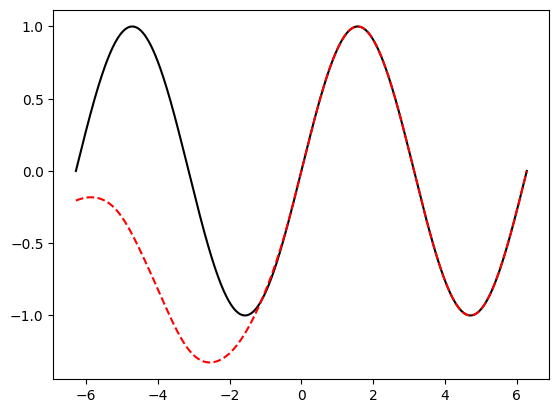

In [ ]:
x_true = np.linspace(0, np.pi*2, 10000)
x_noise = noise(x_true,0.2)
y_noise = np.sin(x_noise)
dy_noise = np.cos(x_noise)

# Definimos la estructura de la función que queremos aprender.
x = Variable('x')
y = Functional('y', x, 3*[40], activation=['tanh']+ ['g-cos', 'l-sin'])

# Imponemos restricciones al modelo.
dy_dx = sn.diff(y, x)
c1 = Data(y)

# Definimos el modelo.
model = SciModel(x, [y, dy_dx], optimizer='adam')
model.summary()
# Entrenamiento.

start_time = time.time()
entrenamiento_sin_noise = model.train(x_noise,
            [y_noise, dy_noise],
            epochs=200,
            learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-3,
                           "final_learning_rate": 1e-5,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            # adaptive_weights={'method': "SASW", "eta": 0.1, "d_mask_func": lambda x: np.exp(x)},
            adaptive_weights={'method': "CLW", 'initial_weights': [0.1, 1.], 'final_weights': [2., 3.], 'curriculum_epochs': 20, "delay_epochs": 10},
            save_weights={'path': 'test', 'freq': 100}
            )

print(f"Duración del entrenamiento: {time.time()-start_time}s. ")

# Predicción
x_test = np.linspace(-np.pi*2, np.pi*2, 20000)
y_test = np.sin(x_test)
y_pred_test = y.eval(model, x_test)

# Mostramos los resultados
plt.plot(x_test, y_test, '-k', x_test, y_pred_test, '--r')
plt.show()

In [ ]:
x_true = np.linspace(0, np.pi*2, 10000)
y_true = np.sin(x_true)
dy_true = np.cos(x_true)

# Definimos la estructura de la función que queremos aprender.
x = Variable('x')
y = Functional('y', x, 8*[20], activation=6*['tanh']+ ['g-cos', 'l-sin'])

# Imponemos restricciones al modelo.
dy_dx = sn.diff(y, x)
c1 = Data(y)

# Definimos el modelo.
model = SciModel(x, [y, dy_dx], optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D20b (Dense)                (None, 20)                40        
                                                                 
 sci_rowdy_activation_layer   (None, 20)               29        
 (SciRowdyActivationLayer)                                       
                                                                 
 D20b_2 (Dense)              (None, 20)                420       
                                                                 
 sci_rowdy_activation_layer_  (None, 20)               29        
 1 (SciRowdyActivationLayer)                                     
                                                                 
 D20b_3 (Dense)              (None, 20)                420   

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 x (InputLayer)              [(None, 1)]               0         
                                                                 
 D10b_4 (Dense)              (None, 10)                20        
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               14        
 3 (SciRowdyActivationLayer)                                     
                                                                 
 D10b_5 (Dense)              (None, 10)                110       
                                                                 
 sci_rowdy_activation_layer_  (None, 10)               14        
 4 (SciRowdyActivationLayer)                                     
                                                                 
 D10b_6 (Dense)              (None, 10)                110 

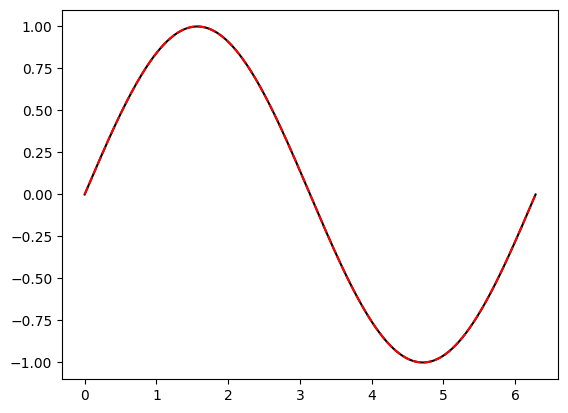

In [ ]:
# Generación de datos sintéticos.
x_true = np.linspace(0, np.pi*2, 10000)
y_true = np.sin(x_true)
dy_true = np.cos(x_true)

# Definimos la estructura de la función que queremos aprender.
x = Variable('x')
y = Functional('y', x, [10, 10, 10], activation=['tanh', 'g-cos', 'l-sin'])

# Imponemos restricciones al modelo.
dy_dx = sn.diff(y, x)
c1 = Data(y)

# Definimos el modelo.
model = SciModel(x, [y, dy_dx], optimizer='adam',plot_to_file='sin.png')
model.summary()

start_time = time.time()

# Entrenamiento.
entrenamiento_sin = model.train(x_true,
            [y_true, dy_true],
            epochs=200,
            learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-3,
                           "final_learning_rate": 1e-5,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            # adaptive_weights={'method': "SASW", "eta": 0.1, "d_mask_func": lambda x: np.exp(x)},
            adaptive_weights={'method': "CLW", 'initial_weights': [0.1, 1.], 'final_weights': [2., 3.], 'curriculum_epochs': 20, "delay_epochs": 10},
            save_weights={'path': 'test', 'freq': 100}
            )

print(f"Duración del entrenamiento: {time.time()-start_time}s. ")

# Predicción
y_pred = y.eval(model, x_true)

# Mostramos los resultados
plt.plot(x_true, y_true, '-k', x_true, y_pred, '--r')
plt.show()

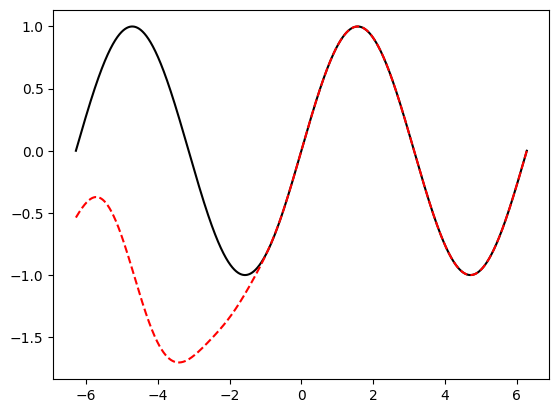

In [ ]:
x_test = np.linspace(-np.pi*2, np.pi*2, 20000)
y_test = np.sin(x_test)
y_pred_test = y.eval(model, x_test)

# Mostramos los resultados
plt.plot(x_test, y_test, '-k', x_test, y_pred_test, '--r')
plt.show()

Text(0, 0.5, 'Pérdida')

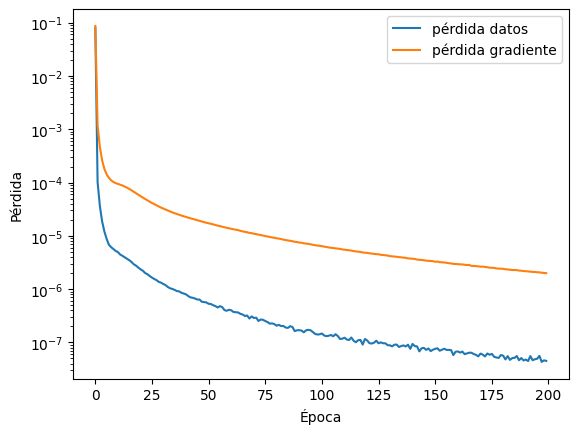

In [ ]:
plt.semilogy(entrenamiento_sin.history['y_loss'],label="pérdida datos")
plt.semilogy(entrenamiento_sin.history['Grad__2_loss'],label="pérdida gradiente")
plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida')

## 1.2. Ajuste de la curva $y = exp(x)$ en el intervalo $[0,1]$.

In [ ]:
x_true = np.linspace(0, 1, 1000)
y_true = np.exp(x_true)
dy_true = np.exp(x_true)

x_test = np.linspace(0, 2, 2000)
y_test = np.exp(x_test)

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'n_layers': {
        'values': [1,3,5,7]
        },
    'n_in_layer': {
        'values': [20,40,80]
        },
    'activation': {
        'values': ['relu','sigmoid','tanh']
        },
    'lr': {
        'values': [1,0.1,0.01,0.001]
        },
    'bz': {
        'values': [32,64,128]
        }
    }

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'activation': {'values': ['relu', 'sigmoid', 'tanh']},
                'bz': {'values': [32, 64, 128]},
                'lr': {'values': [1, 0.1, 0.01, 0.001]},
                'n_in_layer': {'values': [20, 40, 80]},
                'n_layers': {'values': [1, 3, 5, 7]}}}


In [ ]:
def sweep_train_exp(config_defaults=None):
    with wandb.init(config=config_defaults,project="experimento-1-exp"):

          # Definimos la estructura de la función que queremos aprender.
          x = Variable('x')
          y = Functional('y', x, wandb.config.n_layers*[wandb.config.n_in_layer], activation=wandb.config.n_layers*[wandb.config.activation])

          # Imponemos restricciones al modelo.
          dy_dx = sn.diff(y, x)
          c1 = Data(y)

          # Definimos el modelo.
          model = SciModel(x, [y, dy_dx], optimizer='adam')

          start_time = time.time()

          # Entrenamiento.
          entrenamiento_exp = model.train(x_true,
                      [y_true, dy_true],
                      epochs=10000,
                      learning_rate=wandb.config.lr,
                      batch_size=wandb.config.bz,
                      callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=20,verbose=1)]
                      )

          print(f"Duración del entrenamiento: {time.time()-start_time}s. ")
          end_time = time.time()
          # Predicción
          y_pred = y.eval(model, x_test)
          wandb.log(
          {
              'loss': min(entrenamiento_exp.history['loss']),
              'val_loss': np.mean((y_test-y_pred)**2),
              'time': end_time - start_time
          })
          wandb.finish()

In [ ]:
sweep_exp = wandb.sweep(sweep_config, project="experimento-1-exp")

Create sweep with ID: cu4kt7t2
Sweep URL: https://wandb.ai/vaatiper-Universidad%20de%20Granada/experimento-1-exp/sweeps/cu4kt7t2


In [ ]:
wandb.agent(sweep_exp,function=sweep_train_exp,count=20)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: 2pnjsgtx with config:
wandb: 	activation: sigmoid
wandb: 	bz: 64
wandb: 	lr: 1
wandb: 	n_in_layer: 20
wandb: 	n_layers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run 2pnjsgtx errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 307, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-31-2599294559f5>", line 2, in sweep_train_exp
wandb: ERROR     with wandb.init(config=config_defaults,project="experimento-1-exp"):
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 1195, in init
wandb: ERROR     wandb._sentry.reraise(e)
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/analytics/sentry.py", line 155, in reraise
wandb: ERROR     raise exc.with_traceback(sys.exc_info()[2])
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 1181, in init
wandb: ERROR     return wi.init()
wandb: ERROR   File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_init.py", line 785, in init
wandb: ERROR     raise error
wandb: ERROR 


Total samples: 1000 
Batch size: 32 
Total batches: 32 

Epoch 1/10000
32/32 [==============================] - 9s 23ms/step - batch: 15.5000 - size: 31.2500 - loss: 3.6069 - y_loss: 0.4173 - Grad__22_loss: 3.1893 - lr: 0.0100 - time: 8.8861
Epoch 2/10000
32/32 [==============================] - 1s 19ms/step - batch: 15.5000 - size: 31.2500 - loss: 2.1242 - y_loss: 0.1719 - Grad__22_loss: 1.9509 - lr: 0.0100 - time: 0.6031
Epoch 3/10000
32/32 [==============================] - 1s 20ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.1406 - y_loss: 0.0356 - Grad__22_loss: 0.1052 - lr: 0.0100 - time: 0.6552
Epoch 4/10000
32/32 [==============================] - 1s 21ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.0054 - y_loss: 0.0017 - Grad__22_loss: 0.0038 - lr: 0.0100 - time: 0.6651
Epoch 5/10000
32/32 [==============================] - 1s 19ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.0014 - y_loss: 6.5704e-05 - Grad__22_loss: 0.0013 - lr: 0.0100 - time: 0.6082
Epoch 6/10000

wandb: Agent Starting Run: 2w0zqsz9 with config:
wandb: 	activation: relu
wandb: 	bz: 128
wandb: 	lr: 0.001
wandb: 	n_in_layer: 80
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 128 
Total batches: 8 

Epoch 1/10000
8/8 [==============================] - 8s 29ms/step - batch: 3.5000 - size: 125.0000 - loss: 2.3081 - y_loss: 1.1915 - Grad__23_loss: 1.1121 - lr: 0.0010 - time: 8.4804
Epoch 2/10000
8/8 [==============================] - 0s 15ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.6864 - y_loss: 0.2027 - Grad__23_loss: 0.4836 - lr: 0.0010 - time: 0.1261
Epoch 3/10000
8/8 [==============================] - 0s 17ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.4111 - y_loss: 0.1799 - Grad__23_loss: 0.2316 - lr: 0.0010 - time: 0.1832
Epoch 4/10000
8/8 [==============================] - 0s 20ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.2982 - y_loss: 0.0366 - Grad__23_loss: 0.2618 - lr: 0.0010 - time: 0.2176
Epoch 5/10000
8/8 [==============================] - 0s 27ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.2049 - y_loss: 0.0348 - Grad__23_loss: 0.1701 - lr: 0.0010 - time: 0.2545
Epoch 6/10000
8/8 [========

wandb: Agent Starting Run: 3ewvhrxb with config:
wandb: 	activation: tanh
wandb: 	bz: 128
wandb: 	lr: 0.01
wandb: 	n_in_layer: 20
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 128 
Total batches: 8 

Epoch 1/10000
8/8 [==============================] - 6s 14ms/step - batch: 3.5000 - size: 125.0000 - loss: 2.8708 - y_loss: 0.8168 - Grad__24_loss: 2.0541 - lr: 0.0100 - time: 5.6780
Epoch 2/10000
8/8 [==============================] - 0s 9ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.3856 - y_loss: 0.0627 - Grad__24_loss: 0.3235 - lr: 0.0100 - time: 0.1106
Epoch 3/10000
8/8 [==============================] - 0s 6ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.1961 - y_loss: 0.0486 - Grad__24_loss: 0.1480 - lr: 0.0100 - time: 0.0734
Epoch 4/10000
8/8 [==============================] - 0s 8ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.1149 - y_loss: 0.0058 - Grad__24_loss: 0.1091 - lr: 0.0100 - time: 0.1096
Epoch 5/10000
8/8 [==============================] - 0s 6ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.0561 - y_loss: 0.0106 - Grad__24_loss: 0.0455 - lr: 0.0100 - time: 0.0751
Epoch 6/10000
8/8 [============

wandb: Agent Starting Run: 4b6x53k0 with config:
wandb: 	activation: tanh
wandb: 	bz: 64
wandb: 	lr: 0.1
wandb: 	n_in_layer: 80
wandb: 	n_layers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 64 
Total batches: 16 

Epoch 1/10000
16/16 [==============================] - 0s 3ms/step - batch: 7.5000 - size: 62.5000 - loss: 4.0301 - y_loss: 1.2922 - Grad__25_loss: 2.7366 - lr: 0.1000 - time: 0.4634
Epoch 2/10000
16/16 [==============================] - 0s 2ms/step - batch: 7.5000 - size: 62.5000 - loss: 0.4593 - y_loss: 0.2624 - Grad__25_loss: 0.1966 - lr: 0.1000 - time: 0.1037
Epoch 3/10000
16/16 [==============================] - 0s 2ms/step - batch: 7.5000 - size: 62.5000 - loss: 0.1323 - y_loss: 0.0523 - Grad__25_loss: 0.0799 - lr: 0.1000 - time: 0.1154
Epoch 4/10000
16/16 [==============================] - 0s 2ms/step - batch: 7.5000 - size: 62.5000 - loss: 0.0519 - y_loss: 0.0100 - Grad__25_loss: 0.0419 - lr: 0.1000 - time: 0.1169
Epoch 5/10000
16/16 [==============================] - 0s 3ms/step - batch: 7.5000 - size: 62.5000 - loss: 0.0222 - y_loss: 0.0025 - Grad__25_loss: 0.0196 - lr: 0.1000 - time: 0.1189
Epoch 6/10000
16/16 [======

wandb: Agent Starting Run: psj32hxz with config:
wandb: 	activation: tanh
wandb: 	bz: 32
wandb: 	lr: 0.1
wandb: 	n_in_layer: 40
wandb: 	n_layers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 32 
Total batches: 32 

Epoch 1/10000
32/32 [==============================] - 1s 3ms/step - batch: 15.5000 - size: 31.2500 - loss: 1.0212 - y_loss: 0.3103 - Grad__26_loss: 0.7103 - lr: 0.1000 - time: 0.6640
Epoch 2/10000
32/32 [==============================] - 0s 3ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.0435 - y_loss: 0.0115 - Grad__26_loss: 0.0320 - lr: 0.1000 - time: 0.1621
Epoch 3/10000
32/32 [==============================] - 0s 3ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.0085 - y_loss: 0.0012 - Grad__26_loss: 0.0072 - lr: 0.1000 - time: 0.1632
Epoch 4/10000
32/32 [==============================] - 0s 3ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.0042 - y_loss: 1.7916e-04 - Grad__26_loss: 0.0040 - lr: 0.1000 - time: 0.1636
Epoch 5/10000
32/32 [==============================] - 0s 4ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.0023 - y_loss: 1.9300e-04 - Grad__26_loss: 0.0021 - lr: 0.1000 - time: 0.2043
Epoch 6/10000


wandb: Agent Starting Run: 9uqhkw18 with config:
wandb: 	activation: sigmoid
wandb: 	bz: 32
wandb: 	lr: 0.001
wandb: 	n_in_layer: 40
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 32 
Total batches: 32 

Epoch 1/10000
32/32 [==============================] - 8s 13ms/step - batch: 15.5000 - size: 31.2500 - loss: 4.4679 - y_loss: 1.2676 - Grad__27_loss: 3.2003 - lr: 0.0010 - time: 8.4083
Epoch 2/10000
32/32 [==============================] - 0s 14ms/step - batch: 15.5000 - size: 31.2500 - loss: 3.4857 - y_loss: 0.2739 - Grad__27_loss: 3.2123 - lr: 0.0010 - time: 0.4674
Epoch 3/10000
32/32 [==============================] - 1s 20ms/step - batch: 15.5000 - size: 31.2500 - loss: 3.4138 - y_loss: 0.2436 - Grad__27_loss: 3.1699 - lr: 0.0010 - time: 0.6385
Epoch 4/10000
32/32 [==============================] - 1s 18ms/step - batch: 15.5000 - size: 31.2500 - loss: 2.7493 - y_loss: 0.1907 - Grad__27_loss: 2.5598 - lr: 0.0010 - time: 0.5976
Epoch 5/10000
32/32 [==============================] - 1s 21ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.5127 - y_loss: 0.0270 - Grad__27_loss: 0.4854 - lr: 0.0010 - time: 0.6870
Epoch 6/10000
32/

wandb: Agent Starting Run: 0g0okn9f with config:
wandb: 	activation: tanh
wandb: 	bz: 128
wandb: 	lr: 0.1
wandb: 	n_in_layer: 80
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 128 
Total batches: 8 

Epoch 1/10000
8/8 [==============================] - 5s 16ms/step - batch: 3.5000 - size: 125.0000 - loss: 183.5196 - y_loss: 12.3022 - Grad__28_loss: 171.1375 - lr: 0.1000 - time: 4.5838
Epoch 2/10000
8/8 [==============================] - 0s 9ms/step - batch: 3.5000 - size: 125.0000 - loss: 3.5685 - y_loss: 0.3657 - Grad__28_loss: 3.2027 - lr: 0.1000 - time: 0.0834
Epoch 3/10000
8/8 [==============================] - 0s 10ms/step - batch: 3.5000 - size: 125.0000 - loss: 3.7456 - y_loss: 0.5343 - Grad__28_loss: 3.2109 - lr: 0.1000 - time: 0.1498
Epoch 4/10000
8/8 [==============================] - 0s 10ms/step - batch: 3.5000 - size: 125.0000 - loss: 3.5575 - y_loss: 0.3642 - Grad__28_loss: 3.1931 - lr: 0.1000 - time: 0.0905
Epoch 5/10000
8/8 [==============================] - 0s 10ms/step - batch: 3.5000 - size: 125.0000 - loss: 3.5016 - y_loss: 0.3096 - Grad__28_loss: 3.1916 - lr: 0.1000 - time: 0.1020
Epoch 6/10000
8/8 [====

wandb: Agent Starting Run: 9gazahr6 with config:
wandb: 	activation: relu
wandb: 	bz: 128
wandb: 	lr: 1
wandb: 	n_in_layer: 80
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 128 
Total batches: 8 

Epoch 1/10000
8/8 [==============================] - 1s 8ms/step - batch: 3.5000 - size: 125.0000 - loss: 85005757800.1496 - y_loss: 49407918080.0000 - Grad__29_loss: 35371962368.0000 - lr: 1.0000 - time: 1.4607
Epoch 2/10000
8/8 [==============================] - 0s 5ms/step - batch: 3.5000 - size: 125.0000 - loss: 6920060868.4373 - y_loss: 6903611904.0000 - Grad__29_loss: 3.1921 - lr: 1.0000 - time: 0.0482
Epoch 3/10000
8/8 [==============================] - 0s 6ms/step - batch: 3.5000 - size: 125.0000 - loss: 3557099450.1120 - y_loss: 3550996736.0000 - Grad__29_loss: 3.1904 - lr: 1.0000 - time: 0.1033
Epoch 4/10000
8/8 [==============================] - 0s 6ms/step - batch: 3.5000 - size: 125.0000 - loss: 1457784706.4250 - y_loss: 1457407744.0000 - Grad__29_loss: 3.1983 - lr: 1.0000 - time: 0.0952
Epoch 5/10000
8/8 [==============================] - 0s 10ms/step - batch: 3.5000 - size: 125.0000 - loss: 241242064.0732 - y_loss

wandb: Agent Starting Run: ubyt98xq with config:
wandb: 	activation: relu
wandb: 	bz: 64
wandb: 	lr: 0.1
wandb: 	n_in_layer: 40
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 64 
Total batches: 16 

Epoch 1/10000
16/16 [==============================] - 9s 17ms/step - batch: 7.5000 - size: 62.5000 - loss: 170.6947 - y_loss: 26.3584 - Grad__30_loss: 146.6637 - lr: 0.1000 - time: 8.6684
Epoch 2/10000
16/16 [==============================] - 0s 12ms/step - batch: 7.5000 - size: 62.5000 - loss: 87.4979 - y_loss: 31.2688 - Grad__30_loss: 56.1133 - lr: 0.1000 - time: 0.1947
Epoch 3/10000
16/16 [==============================] - 0s 11ms/step - batch: 7.5000 - size: 62.5000 - loss: 4.7400 - y_loss: 1.2850 - Grad__30_loss: 3.4550 - lr: 0.1000 - time: 0.2369
Epoch 4/10000
16/16 [==============================] - 0s 11ms/step - batch: 7.5000 - size: 62.5000 - loss: 3.1318 - y_loss: 0.3960 - Grad__30_loss: 2.7356 - lr: 0.1000 - time: 0.2492
Epoch 5/10000
16/16 [==============================] - 0s 12ms/step - batch: 7.5000 - size: 62.5000 - loss: 3.5196 - y_loss: 0.3164 - Grad__30_loss: 3.2036 - lr: 0.1000 - time: 0.2650
Epoch 6/10000


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ktv0dco7 with config:
wandb: 	activation: sigmoid
wandb: 	bz: 128
wandb: 	lr: 1
wandb: 	n_in_layer: 20
wandb: 	n_layers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 128 
Total batches: 8 

Epoch 1/10000
8/8 [==============================] - 1s 5ms/step - batch: 3.5000 - size: 125.0000 - loss: 28.6636 - y_loss: 26.1882 - Grad__31_loss: 2.4530 - lr: 1.0000 - time: 0.5042
Epoch 2/10000
8/8 [==============================] - 0s 3ms/step - batch: 3.5000 - size: 125.0000 - loss: 5.5019 - y_loss: 3.0419 - Grad__31_loss: 2.4534 - lr: 1.0000 - time: 0.0726
Epoch 3/10000
8/8 [==============================] - 0s 3ms/step - batch: 3.5000 - size: 125.0000 - loss: 3.1486 - y_loss: 2.6168 - Grad__31_loss: 0.5245 - lr: 1.0000 - time: 0.0897
Epoch 4/10000
8/8 [==============================] - 0s 3ms/step - batch: 3.5000 - size: 125.0000 - loss: 1.3633 - y_loss: 0.6550 - Grad__31_loss: 0.7082 - lr: 1.0000 - time: 0.0961
Epoch 5/10000
8/8 [==============================] - 0s 3ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.4325 - y_loss: 0.1178 - Grad__31_loss: 0.3145 - lr: 1.0000 - time: 0.0927
Epoch 6/10000
8/8 [===========

wandb: Agent Starting Run: 58y0q66i with config:
wandb: 	activation: tanh
wandb: 	bz: 128
wandb: 	lr: 0.01
wandb: 	n_in_layer: 40
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 128 
Total batches: 8 

Epoch 1/10000
8/8 [==============================] - 5s 17ms/step - batch: 3.5000 - size: 125.0000 - loss: 3.3415 - y_loss: 0.8786 - Grad__32_loss: 2.4602 - lr: 0.0100 - time: 4.8238
Epoch 2/10000
8/8 [==============================] - 0s 7ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.8039 - y_loss: 0.1027 - Grad__32_loss: 0.7013 - lr: 0.0100 - time: 0.0679
Epoch 3/10000
8/8 [==============================] - 0s 7ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.3006 - y_loss: 0.0957 - Grad__32_loss: 0.2046 - lr: 0.0100 - time: 0.0948
Epoch 4/10000
8/8 [==============================] - 0s 8ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.1856 - y_loss: 0.0194 - Grad__32_loss: 0.1662 - lr: 0.0100 - time: 0.1040
Epoch 5/10000
8/8 [==============================] - 0s 10ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.1343 - y_loss: 0.0154 - Grad__32_loss: 0.1191 - lr: 0.0100 - time: 0.1042
Epoch 6/10000
8/8 [===========

wandb: Agent Starting Run: a6dzrgq0 with config:
wandb: 	activation: sigmoid
wandb: 	bz: 64
wandb: 	lr: 1
wandb: 	n_in_layer: 40
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 64 
Total batches: 16 

Epoch 1/10000
16/16 [==============================] - 6s 21ms/step - batch: 7.5000 - size: 62.5000 - loss: 1359.4460 - y_loss: 1354.5542 - Grad__33_loss: 3.1965 - lr: 1.0000 - time: 5.7727
Epoch 2/10000
16/16 [==============================] - 0s 17ms/step - batch: 7.5000 - size: 62.5000 - loss: 181.4518 - y_loss: 178.6339 - Grad__33_loss: 3.1912 - lr: 1.0000 - time: 0.2815
Epoch 3/10000
16/16 [==============================] - 0s 14ms/step - batch: 7.5000 - size: 62.5000 - loss: 31.0140 - y_loss: 27.8238 - Grad__33_loss: 3.1982 - lr: 1.0000 - time: 0.2260
Epoch 4/10000
16/16 [==============================] - 0s 13ms/step - batch: 7.5000 - size: 62.5000 - loss: 6.4398 - y_loss: 3.2471 - Grad__33_loss: 3.1902 - lr: 1.0000 - time: 0.2721
Epoch 5/10000
16/16 [==============================] - 0s 8ms/step - batch: 7.5000 - size: 62.5000 - loss: 4.0470 - y_loss: 0.8422 - Grad__33_loss: 3.2053 - lr: 1.0000 - time: 0.1781
Epoch 6/100

wandb: Agent Starting Run: gmo02hya with config:
wandb: 	activation: sigmoid
wandb: 	bz: 32
wandb: 	lr: 0.01
wandb: 	n_in_layer: 40
wandb: 	n_layers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 32 
Total batches: 32 

Epoch 1/10000
32/32 [==============================] - 1s 3ms/step - batch: 15.5000 - size: 31.2500 - loss: 1.6227 - y_loss: 0.3442 - Grad__34_loss: 1.2789 - lr: 0.0100 - time: 0.5008
Epoch 2/10000
32/32 [==============================] - 0s 2ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.4204 - y_loss: 0.0139 - Grad__34_loss: 0.4064 - lr: 0.0100 - time: 0.1370
Epoch 3/10000
32/32 [==============================] - 0s 3ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.3435 - y_loss: 0.0059 - Grad__34_loss: 0.3376 - lr: 0.0100 - time: 0.1566
Epoch 4/10000
32/32 [==============================] - 0s 3ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.2921 - y_loss: 0.0048 - Grad__34_loss: 0.2872 - lr: 0.0100 - time: 0.1553
Epoch 5/10000
32/32 [==============================] - 0s 2ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.2571 - y_loss: 0.0042 - Grad__34_loss: 0.2529 - lr: 0.0100 - time: 0.1528
Epoch 6/10000
32/32 [=

wandb: Agent Starting Run: 5ihgxofv with config:
wandb: 	activation: relu
wandb: 	bz: 64
wandb: 	lr: 1
wandb: 	n_in_layer: 20
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 64 
Total batches: 16 

Epoch 1/10000
16/16 [==============================] - 9s 9ms/step - batch: 1.5000 - size: 64.0000 - loss: nan - y_loss: nan - Grad__35_loss: nan - lr: 1.0000 - time: 9.1312
Duración del entrenamiento: 9.5958890914917s. 


wandb: Agent Starting Run: emozreif with config:
wandb: 	activation: relu
wandb: 	bz: 32
wandb: 	lr: 0.001
wandb: 	n_in_layer: 20
wandb: 	n_layers: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 32 
Total batches: 32 

Epoch 1/10000
32/32 [==============================] - 2s 4ms/step - batch: 15.5000 - size: 31.2500 - loss: 2.0031 - y_loss: 1.1295 - Grad__36_loss: 0.8734 - lr: 0.0010 - time: 1.5619
Epoch 2/10000
32/32 [==============================] - 0s 5ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.4649 - y_loss: 0.0994 - Grad__36_loss: 0.3654 - lr: 0.0010 - time: 0.1958
Epoch 3/10000
32/32 [==============================] - 0s 9ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.3254 - y_loss: 0.0493 - Grad__36_loss: 0.2762 - lr: 0.0010 - time: 0.3276
Epoch 4/10000
32/32 [==============================] - 0s 6ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.2356 - y_loss: 0.0130 - Grad__36_loss: 0.2226 - lr: 0.0010 - time: 0.2197
Epoch 5/10000
32/32 [==============================] - 0s 6ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.2028 - y_loss: 0.0056 - Grad__36_loss: 0.1973 - lr: 0.0010 - time: 0.2227
Epoch 6/10000
32/32 [=

wandb: Agent Starting Run: lusngto4 with config:
wandb: 	activation: tanh
wandb: 	bz: 64
wandb: 	lr: 0.01
wandb: 	n_in_layer: 40
wandb: 	n_layers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 64 
Total batches: 16 

Epoch 1/10000
16/16 [==============================] - 0s 3ms/step - batch: 7.5000 - size: 62.5000 - loss: 1.8108 - y_loss: 0.5143 - Grad__37_loss: 1.2961 - lr: 0.0100 - time: 0.4263
Epoch 2/10000
16/16 [==============================] - 0s 2ms/step - batch: 7.5000 - size: 62.5000 - loss: 0.6871 - y_loss: 0.0308 - Grad__37_loss: 0.6559 - lr: 0.0100 - time: 0.1127
Epoch 3/10000
16/16 [==============================] - 0s 2ms/step - batch: 7.5000 - size: 62.5000 - loss: 0.2964 - y_loss: 0.0096 - Grad__37_loss: 0.2868 - lr: 0.0100 - time: 0.1195
Epoch 4/10000
16/16 [==============================] - 0s 3ms/step - batch: 7.5000 - size: 62.5000 - loss: 0.1218 - y_loss: 0.0033 - Grad__37_loss: 0.1185 - lr: 0.0100 - time: 0.1236
Epoch 5/10000
16/16 [==============================] - 0s 3ms/step - batch: 7.5000 - size: 62.5000 - loss: 0.0688 - y_loss: 0.0017 - Grad__37_loss: 0.0671 - lr: 0.0100 - time: 0.1231
Epoch 6/10000
16/16 [======

wandb: Agent Starting Run: sjrwr4m5 with config:
wandb: 	activation: tanh
wandb: 	bz: 32
wandb: 	lr: 1
wandb: 	n_in_layer: 40
wandb: 	n_layers: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 32 
Total batches: 32 

Epoch 1/10000
32/32 [==============================] - 10s 16ms/step - batch: 15.5000 - size: 31.2500 - loss: 816.4790 - y_loss: 814.7552 - Grad__38_loss: 3.1832 - lr: 1.0000 - time: 9.7420
Epoch 2/10000
32/32 [==============================] - 0s 12ms/step - batch: 15.5000 - size: 31.2500 - loss: 17.8294 - y_loss: 14.6415 - Grad__38_loss: 3.1847 - lr: 1.0000 - time: 0.3770
Epoch 3/10000
32/32 [==============================] - 0s 11ms/step - batch: 15.5000 - size: 31.2500 - loss: 3.8004 - y_loss: 0.5965 - Grad__38_loss: 3.2047 - lr: 1.0000 - time: 0.4075
Epoch 4/10000
32/32 [==============================] - 0s 12ms/step - batch: 15.5000 - size: 31.2500 - loss: 3.4486 - y_loss: 0.2579 - Grad__38_loss: 3.1906 - lr: 1.0000 - time: 0.4546
Epoch 5/10000
32/32 [==============================] - 0s 12ms/step - batch: 15.5000 - size: 31.2500 - loss: 3.4594 - y_loss: 0.2543 - Grad__38_loss: 3.2054 - lr: 1.0000 - time: 0.4505
Epoch 6/10

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fa2ryr3w with config:
wandb: 	activation: relu
wandb: 	bz: 128
wandb: 	lr: 0.001
wandb: 	n_in_layer: 40
wandb: 	n_layers: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 128 
Total batches: 8 

Epoch 1/10000
8/8 [==============================] - 5s 36ms/step - batch: 3.5000 - size: 125.0000 - loss: 3.0324 - y_loss: 1.7052 - Grad__39_loss: 1.3281 - lr: 0.0010 - time: 4.7195
Epoch 2/10000
8/8 [==============================] - 0s 15ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.7067 - y_loss: 0.2732 - Grad__39_loss: 0.4330 - lr: 0.0010 - time: 0.1198
Epoch 3/10000
8/8 [==============================] - 0s 19ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.5175 - y_loss: 0.0726 - Grad__39_loss: 0.4444 - lr: 0.0010 - time: 0.1741
Epoch 4/10000
8/8 [==============================] - 0s 23ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.2996 - y_loss: 0.1498 - Grad__39_loss: 0.1497 - lr: 0.0010 - time: 0.2221
Epoch 5/10000
8/8 [==============================] - 0s 15ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.2432 - y_loss: 0.0581 - Grad__39_loss: 0.1851 - lr: 0.0010 - time: 0.1451
Epoch 6/10000
8/8 [========

wandb: Agent Starting Run: 9v6sefg9 with config:
wandb: 	activation: sigmoid
wandb: 	bz: 32
wandb: 	lr: 0.001
wandb: 	n_in_layer: 80
wandb: 	n_layers: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.



Total samples: 1000 
Batch size: 32 
Total batches: 32 

Epoch 1/10000
32/32 [==============================] - 1s 3ms/step - batch: 15.5000 - size: 31.2500 - loss: 1.7632 - y_loss: 0.1255 - Grad__40_loss: 1.6385 - lr: 0.0010 - time: 0.5612
Epoch 2/10000
32/32 [==============================] - 0s 2ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.9105 - y_loss: 0.0418 - Grad__40_loss: 0.8686 - lr: 0.0010 - time: 0.1212
Epoch 3/10000
32/32 [==============================] - 0s 2ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.5750 - y_loss: 0.0157 - Grad__40_loss: 0.5594 - lr: 0.0010 - time: 0.1493
Epoch 4/10000
32/32 [==============================] - 0s 2ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.4763 - y_loss: 0.0088 - Grad__40_loss: 0.4675 - lr: 0.0010 - time: 0.1460
Epoch 5/10000
32/32 [==============================] - 0s 2ms/step - batch: 15.5000 - size: 31.2500 - loss: 0.4493 - y_loss: 0.0074 - Grad__40_loss: 0.4420 - lr: 0.0010 - time: 0.1589
Epoch 6/10000
32/32 [=

Selección de modelo

In [ ]:
# Definimos la estructura de la función que queremos aprender.
x = Variable('x')
y = Functional('y', x, 5*[20], activation=5*['tanh'])

# Imponemos restricciones al modelo.
dy_dx = sn.diff(y, x)
c1 = Data(y)

# Definimos el modelo.
model = SciModel(x, [y, dy_dx], optimizer='adam')

start_time = time.time()

# Entrenamiento.
entrenamiento_exp = model.train(x_true,
            [y_true, dy_true],
            epochs=10000,
            learning_rate=0.01,
            batch_size=128,
            callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=20,verbose=1)]
            )

print(f"Duración del entrenamiento: {time.time()-start_time}s. ")
end_time = time.time()


Total samples: 1000 
Batch size: 128 
Total batches: 8 

Epoch 1/10000
8/8 [==============================] - 4s 18ms/step - batch: 3.5000 - size: 125.0000 - loss: 2.2649 - y_loss: 0.5700 - Grad__2_loss: 1.6988 - lr: 0.0100 - time: 4.2948
Epoch 2/10000
8/8 [==============================] - 0s 7ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.2729 - y_loss: 0.0582 - Grad__2_loss: 0.2142 - lr: 0.0100 - time: 0.0551
Epoch 3/10000
8/8 [==============================] - 0s 9ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.1471 - y_loss: 0.0355 - Grad__2_loss: 0.1117 - lr: 0.0100 - time: 0.1589
Epoch 4/10000
8/8 [==============================] - 0s 6ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.0895 - y_loss: 0.0068 - Grad__2_loss: 0.0827 - lr: 0.0100 - time: 0.0755
Epoch 5/10000
8/8 [==============================] - 0s 6ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.0667 - y_loss: 0.0146 - Grad__2_loss: 0.0521 - lr: 0.0100 - time: 0.0980
Epoch 6/10000
8/8 [=================

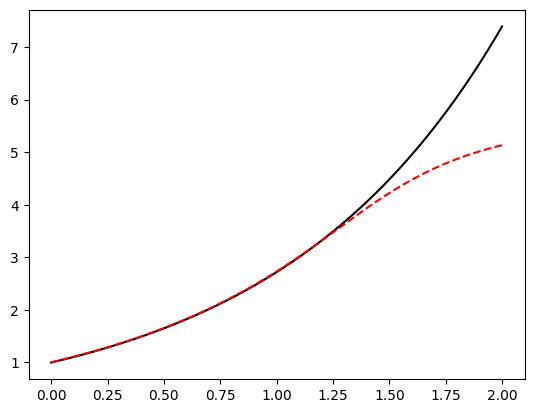

In [ ]:
y_pred_test = y.eval(model, x_test)

# Mostramos los resultados
plt.plot(x_test, y_test, '-k', x_test, y_pred_test, '--r')
plt.show()

Text(0, 0.5, 'Pérdida')

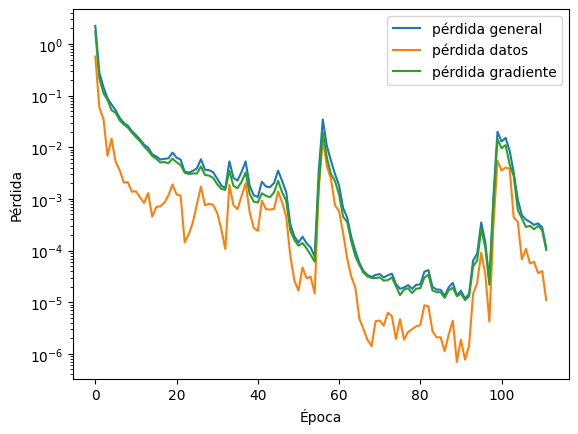

In [ ]:
plt.semilogy(entrenamiento_exp.history['loss'],label="pérdida general")
plt.semilogy(entrenamiento_exp.history['y_loss'],label="pérdida datos")
plt.semilogy(entrenamiento_exp.history['Grad__2_loss'],label="pérdida gradiente")
plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida')

In [ ]:
# Definimos la estructura de la función que queremos aprender.
x = Variable('x')
y = Functional('y', x, 1*[20], activation=1*['sigmoid'])

# Imponemos restricciones al modelo.
dy_dx = sn.diff(y, x)
c1 = Data(y)

# Definimos el modelo.
model = SciModel(x, [y, dy_dx], optimizer='adam')

start_time = time.time()

# Entrenamiento.
entrenamiento_exp = model.train(x_true,
            [y_true, dy_true],
            epochs=10000,
            learning_rate=1,
            batch_size=128,
            callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=20,verbose=1)]
            )

print(f"Duración del entrenamiento: {time.time()-start_time}s. ")
end_time = time.time()


Total samples: 1000 
Batch size: 128 
Total batches: 8 

Epoch 1/10000
8/8 [==============================] - 0s 3ms/step - batch: 3.5000 - size: 125.0000 - loss: 27.2432 - y_loss: 25.7132 - Grad__loss: 1.7453 - lr: 1.0000 - time: 0.4614
Epoch 2/10000
8/8 [==============================] - 0s 2ms/step - batch: 3.5000 - size: 125.0000 - loss: 4.8387 - y_loss: 3.6934 - Grad__loss: 1.1386 - lr: 1.0000 - time: 0.0236
Epoch 3/10000
8/8 [==============================] - 0s 2ms/step - batch: 3.5000 - size: 125.0000 - loss: 2.5385 - y_loss: 1.5314 - Grad__loss: 1.0071 - lr: 1.0000 - time: 0.0962
Epoch 4/10000
8/8 [==============================] - 0s 2ms/step - batch: 3.5000 - size: 125.0000 - loss: 1.6949 - y_loss: 0.5929 - Grad__loss: 1.1034 - lr: 1.0000 - time: 0.0987
Epoch 5/10000
8/8 [==============================] - 0s 2ms/step - batch: 3.5000 - size: 125.0000 - loss: 0.5881 - y_loss: 0.1834 - Grad__loss: 0.4041 - lr: 1.0000 - time: 0.0993
Epoch 6/10000
8/8 [==========================

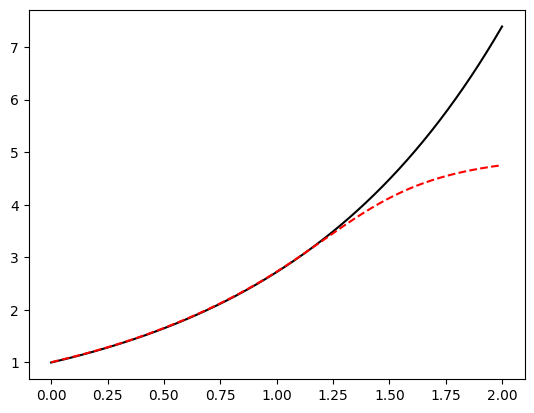

In [ ]:
y_pred_test = y.eval(model, x_test)

# Mostramos los resultados
plt.plot(x_test, y_test, '-k', x_test, y_pred_test, '--r')
plt.show()

Text(0, 0.5, 'Pérdida')

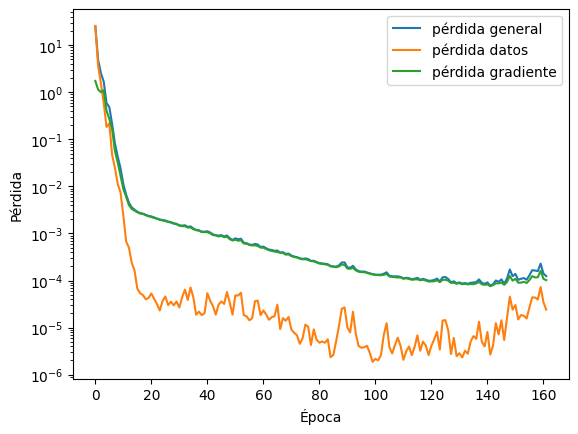

In [ ]:
plt.semilogy(entrenamiento_exp.history['loss'],label="pérdida general")
plt.semilogy(entrenamiento_exp.history['y_loss'],label="pérdida datos")
plt.semilogy(entrenamiento_exp.history['Grad__loss'],label="pérdida gradiente")
plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida')

##1.3. Ajuste de la curva $ z = \sin(x)e^{y}$, $x,y\in [0,\pi]$.

In [ ]:
x_data, y_data = np.meshgrid(
    np.linspace(0, np.pi, 100),
    np.linspace(0, np.pi, 100)
)

f_data = np.sin(x_data) * np.exp(y_data)
df_dx_data = np.cos(x_data) * np.exp(y_data)
df_dy_data = np.sin(x_data) * np.exp(y_data)

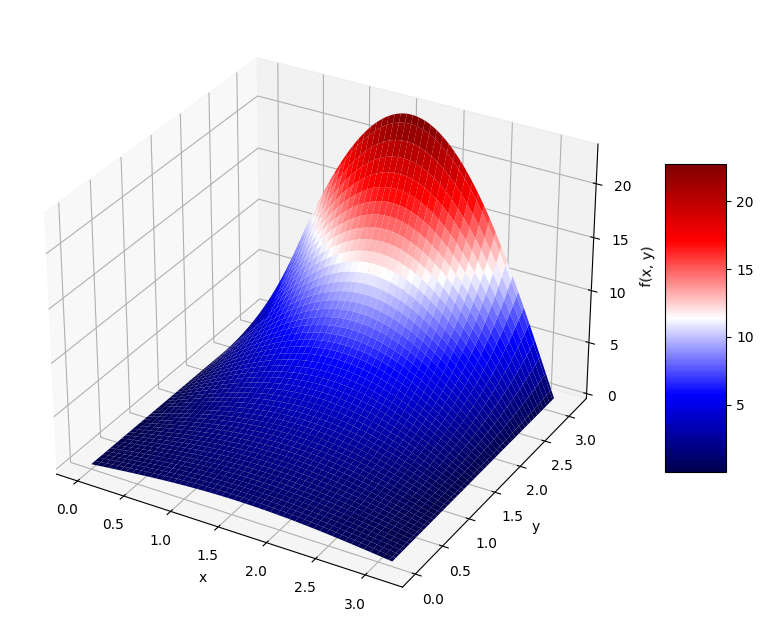

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar superficie 3D
surf = ax.plot_surface(x_data, y_data, f_data, cmap='seismic', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Añadir barra de color

# Etiquetas y título
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

# Mostrar gráfico
plt.show()

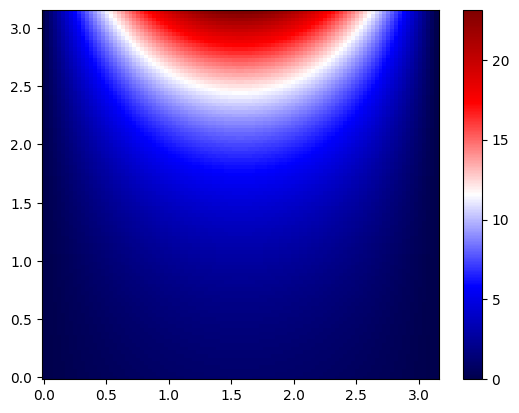

In [ ]:
plt.xlabel('Eje X')
plt.xlabel('Eje Y')
plt.pcolor(x_data, y_data, f_data, cmap='seismic')
plt.colorbar()

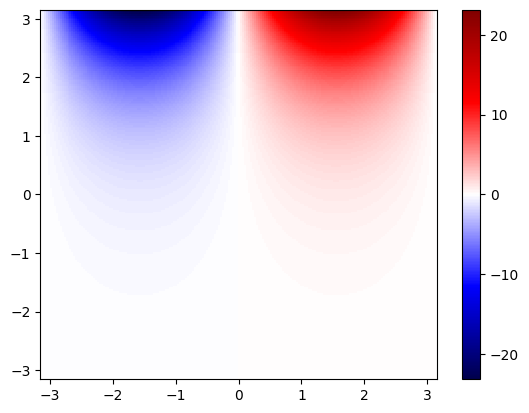

In [ ]:
x_test, y_test = np.meshgrid(
    np.linspace(-np.pi, np.pi, 200),
    np.linspace(-np.pi, np.pi, 200)
)
f_test = np.sin(x_test) * np.exp(y_test)
plt.pcolor(x_test, y_test, f_test, cmap='seismic')
plt.colorbar()

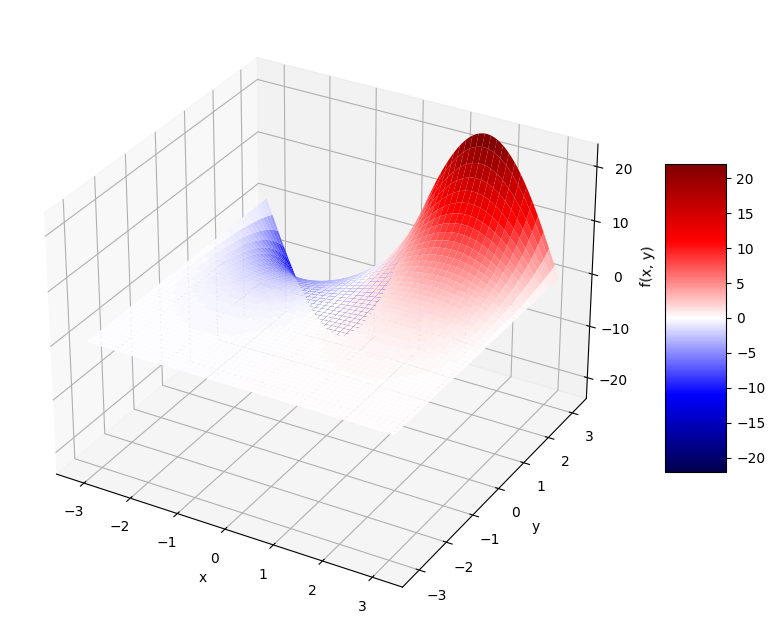

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar superficie 3D
surf = ax.plot_surface(x_test, y_test, f_test, cmap='seismic', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  # Añadir barra de color

# Etiquetas y título
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')

# Mostrar gráfico
plt.show()

In [ ]:
x = sn.Variable('x')
y = sn.Variable('y')
f = sn.Functional('f', [x, y], [10, 10, 10, 10], 'tanh')

df_dx = sn.diff(f, x)
df_dy = sn.diff(f, y)

d1 = sn.Data(f)
modelo_2d = sn.SciModel([x,y],[f, df_dx,df_dy], plot_to_file='2D.png')

In [ ]:
start_time = time.time()
entrenamiento_2d = modelo_2d.train([x_data, y_data], [f_data,df_dx_data,df_dy_data], epochs=500, learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-2,
                           "final_learning_rate": 1e-4,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=10,verbose=0)])

print(f"Duración del entrenamiento: {time.time()-start_time}s. ")


Total samples: 10000 
Batch size: 32 
Total batches: 313 

Epoch 1/500
313/313 [==============================] - 5s 5ms/step - batch: 156.0000 - size: 31.9489 - loss: 33.8216 - f_loss: 7.3629 - Grad__13_loss: 11.4676 - Grad__14_loss: 14.9911 - lr: 0.0100 - time: 5.2743
Epoch 2/500
313/313 [==============================] - 2s 7ms/step - batch: 156.0000 - size: 31.9489 - loss: 1.9202 - f_loss: 0.2650 - Grad__13_loss: 0.7495 - Grad__14_loss: 0.9057 - lr: 0.0063 - time: 2.0993
Epoch 3/500
313/313 [==============================] - 2s 5ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.4223 - f_loss: 0.0599 - Grad__13_loss: 0.1542 - Grad__14_loss: 0.2082 - lr: 0.0040 - time: 1.7065
Epoch 4/500
313/313 [==============================] - 1s 4ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.1770 - f_loss: 0.0173 - Grad__13_loss: 0.0828 - Grad__14_loss: 0.0769 - lr: 0.0025 - time: 1.4110
Epoch 5/500
313/313 [==============================] - 1s 4ms/step - batch: 156.0000 - size: 31.9489 

In [ ]:
entrenamiento_2d = modelo_2d.train([x_data, y_data], [f_data,df_dx_data,df_dy_data], epochs=500, learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-2,
                           "final_learning_rate": 1e-4,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=10,verbose=1)])


Total samples: 10000 
Batch size: 32 
Total batches: 313 

Epoch 1/500
313/313 [==============================] - 2s 6ms/step - batch: 156.0000 - size: 31.9489 - loss: 9.1356 - f_loss: 2.0171 - Grad__7_loss: 3.7644 - Grad__8_loss: 3.3542 - lr: 0.0100 - time: 2.0146
Epoch 2/500
313/313 [==============================] - 1s 4ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.1725 - f_loss: 0.0283 - Grad__7_loss: 0.0823 - Grad__8_loss: 0.0619 - lr: 0.0063 - time: 1.2901
Epoch 3/500
313/313 [==============================] - 1s 4ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0580 - f_loss: 0.0079 - Grad__7_loss: 0.0255 - Grad__8_loss: 0.0247 - lr: 0.0040 - time: 1.2482
Epoch 4/500
313/313 [==============================] - 1s 4ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0341 - f_loss: 0.0034 - Grad__7_loss: 0.0171 - Grad__8_loss: 0.0135 - lr: 0.0025 - time: 1.2478
Epoch 5/500
313/313 [==============================] - 2s 6ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0

Text(0, 0.5, 'Pérdida')

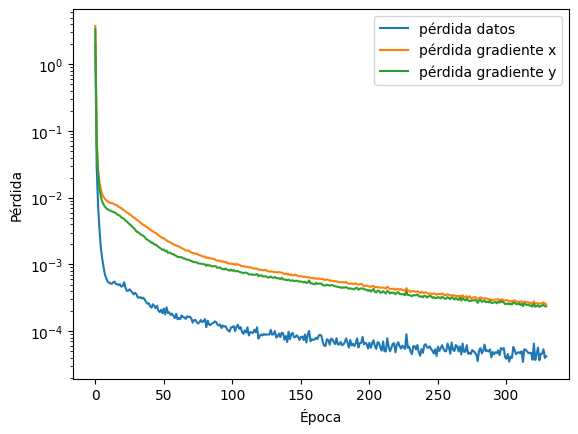

In [ ]:
plt.semilogy(entrenamiento_2d.history['f_loss'],label="pérdida datos")
plt.semilogy(entrenamiento_2d.history['Grad__7_loss'],label="pérdida gradiente x")
plt.semilogy(entrenamiento_2d.history['Grad__8_loss'],label="pérdida gradiente y")

plt.legend()
plt.xlabel('Época')
plt.ylabel('Pérdida')

In [ ]:
x = sn.Variable('x')
y = sn.Variable('y')
f = sn.Functional('f', [x, y], [10, 10, 10, 10], 'tanh')

df_dx = sn.diff(f, x)
df_dy = sn.diff(f, y)

d1 = sn.Data(f)
model_2d = sn.SciModel([x, y], d1, plot_to_file='2D.png')

In [ ]:
history_2d = model_2d.train([x_data, y_data], f_data, epochs=500, learning_rate={"scheduler": "ExponentialDecay",
                           "initial_learning_rate": 1e-2,
                           "final_learning_rate": 1e-5,
                           "decay_epochs": 10,
                           "verify": False},
            batch_size=32,
            callbacks=[keras.callbacks.EarlyStopping(monitor="loss", min_delta = 0, patience=10,verbose=1)])


Total samples: 10000 
Batch size: 32 
Total batches: 313 

Epoch 1/1000
313/313 [==============================] - 1s 2ms/step - batch: 156.0000 - size: 31.9489 - loss: 1.3048 - lr: 0.0100 - time: 0.6093
Epoch 2/1000
313/313 [==============================] - 1s 2ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.3291 - lr: 0.0050 - time: 0.8176
Epoch 3/1000
313/313 [==============================] - 1s 2ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.1496 - lr: 0.0025 - time: 0.7563
Epoch 4/1000
313/313 [==============================] - 2s 8ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.1035 - lr: 0.0013 - time: 2.4955
Epoch 5/1000
313/313 [==============================] - 1s 3ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0829 - lr: 6.3096e-04 - time: 1.1313
Epoch 6/1000
313/313 [==============================] - 2s 5ms/step - batch: 156.0000 - size: 31.9489 - loss: 0.0731 - lr: 3.1623e-04 - time: 1.6998
Epoch 7/1000
313/313 [==============================] - 2s 5ms

In [ ]:
f_pred = f.eval(model_2d, [x_test, y_test])

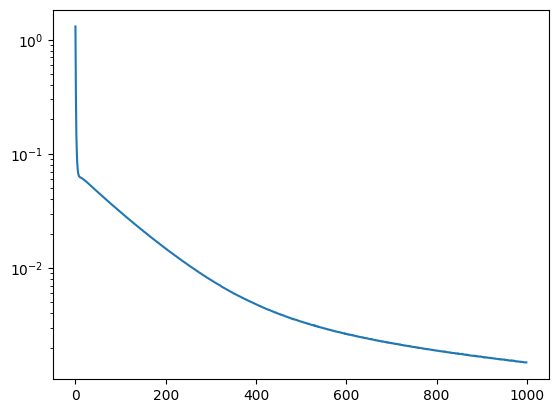

In [ ]:
plt.semilogy(history_2d.history['loss'])

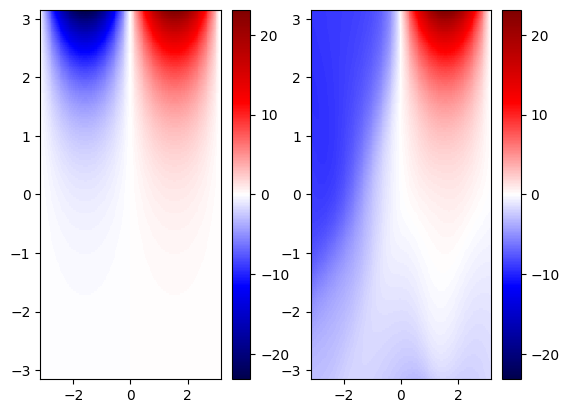

In [ ]:
vmin = min(f_test.min(), f_pred.min())
vmax = max(f_test.max(), f_pred.max())

fig, ax = plt.subplots(1, 2)

im = ax[0].pcolor(x_test, y_test, f_test, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolor(x_test, y_test, f_pred, cmap='seismic', vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[1])

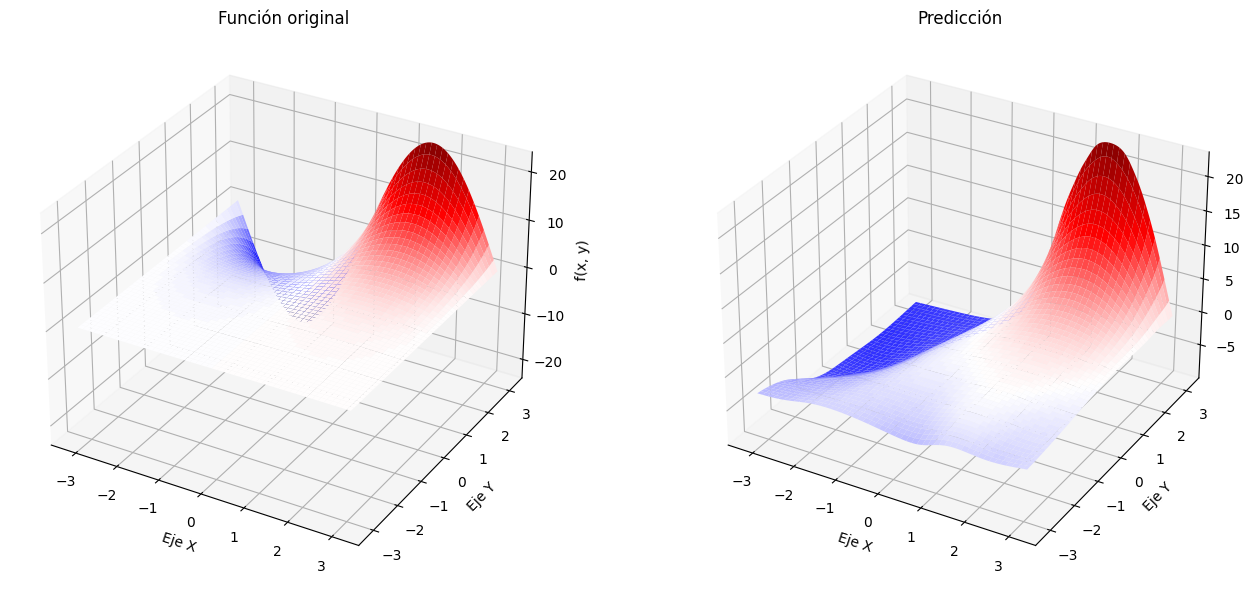

In [ ]:
# Crear figura y ejes 3D
fig = plt.figure(figsize=(14, 6))

# Primer subplot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(x_test, y_test, f_test, cmap='seismic', edgecolor='none',vmin=vmin, vmax=vmax)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax1.set_title('Función original')
ax1.set_xlabel('Eje X')
ax1.set_ylabel('Eje Y')
ax1.set_zlabel('f(x, y)')

# Segundo subplot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_surface(x_test, y_test, f_pred, cmap='seismic', edgecolor='none',vmin=vmin, vmax=vmax)
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax2.set_title('Predicción')
ax2.set_xlabel('Eje X')
ax2.set_ylabel('Eje Y')


# Ajustar diseño y mostrar gráfico
plt.tight_layout()
plt.show()